# Portfolio Optimization - Monte Carlo & Analytical Methods (Markowitz)

## Objective
Find the optimal portfolio allocation to **maximize the Sharpe ratio** using two approaches:
1. **Monte Carlo simulation** (brute force - 10,000 random portfolios)
2. **Analytical optimization** (scipy.optimize - exact solution)

### Workflow:
1. Download stock data and calculate log returns
2. Run Monte Carlo simulation to visualize efficient frontier
3. Use scipy.optimize to find exact optimal allocation
4. Plot efficient frontier with both methods

---

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

%matplotlib inline

## 1. Download Stock Data

In [2]:
# Define period
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('2025-01-01')

# Download closing prices for 4 stocks
aapl = yf.download('AAPL', start=start, end=end)['Close']
cisco = yf.download('CSCO', start=start, end=end)['Close']
ibm = yf.download('IBM', start=start, end=end)['Close']
amzn = yf.download('AMZN', start=start, end=end)['Close']

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7264\653612618.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download('AAPL', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7264\653612618.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cisco = yf.download('CSCO', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7264\653612618.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibm = yf.download('IBM', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7264\653612618.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  amzn = yf.downlo

In [3]:
# Combine into single DataFrame
stocks = pd.concat([aapl, cisco, ibm, amzn], axis=1)
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn']
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2020-01-02,72.400520,40.472343,99.446747,94.900497
2020-01-03,71.696640,39.812019,98.653648,93.748497
2020-01-06,72.267929,39.954117,98.477409,95.143997
2020-01-07,71.928040,39.694992,98.543480,95.343002
2020-01-08,73.085106,39.720074,99.365967,94.598503


## 2. Exploratory Analysis

In [4]:
# Mean daily returns (simple)
stocks.pct_change(1).mean()

aapl     0.001182
cisco    0.000427
ibm      0.000748
amzn     0.000923
dtype: float64

In [5]:
# Correlation matrix
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.543118,0.396052,0.592200
cisco,0.543118,1.000000,0.557482,0.393177
ibm,0.396052,0.557482,1.000000,0.258014
amzn,0.592200,0.393177,0.258014,1.000000


In [6]:
# Preview simple returns
stocks.pct_change(1).head()

,aapl,cisco,ibm,amzn
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.016315,-0.007975,-0.012139
2020-01-06,0.007968,0.003569,-0.001786,0.014886
2020-01-07,-0.004703,-0.006486,0.000671,0.002092
2020-01-08,0.016086,0.000632,0.008346,-0.007809


## 3. Calculate Log Returns

**Why log returns?**
- More efficient for mathematical calculations
- Additive over time: log(Pt/P0) = log(Pt/Pt-1) + log(Pt-1/Pt-2) + ...
- Better statistical properties for portfolio optimization

In [7]:
# Calculate log returns
# log_return = ln(Pt / Pt-1)
log_return = np.log(stocks / stocks.shift(1))
log_return.head()

,aapl,cisco,ibm,amzn
Date,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.009770,-0.016450,-0.008007,-0.012213
2020-01-06,0.007937,0.003563,-0.001788,0.014776
2020-01-07,-0.004714,-0.006507,0.000671,0.002089
2020-01-08,0.015958,0.000632,0.008312,-0.007839


In [8]:
# Mean daily log returns
log_return.mean()

aapl     0.000983
cisco    0.000278
ibm      0.000606
amzn     0.000667
dtype: float64

In [9]:
# Annualized covariance matrix
# Multiply by 252 (trading days per year)
log_return.cov() * 252

,aapl,cisco,ibm,amzn
aapl,0.100198,0.047022,0.033807,0.067700
cisco,0.047022,0.075274,0.040890,0.038877
ibm,0.033807,0.040890,0.071883,0.025113
amzn,0.067700,0.038877,0.025113,0.129304


## 4. Single Portfolio Example

Understanding the mechanics with one random portfolio before running simulations.

In [10]:
np.random.seed(101)

print(stocks.columns)

# Generate random weights
weights = np.array(np.random.random(4))
print('Random weights:')
print(weights)

# Normalize to sum to 1 (100% of capital)
print('Rebalance to sum=1:')
weights = weights / np.sum(weights)
print(weights)

# Expected annual return
# Formula: sum of (mean daily return × weight) × 252 days
print('Expected portfolio return (annual):')
exp_return = np.sum((log_return.mean() * weights) * 252)
print(exp_return)

# Expected annual volatility
# Formula: sqrt(weights^T × Covariance Matrix × weights)
print('Expected volatility (annual):')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
print(exp_vol)

# Sharpe Ratio
# Formula: (Return - Risk_Free_Rate) / Volatility
# Using Rf = 2% (0.02)
print('Sharpe ratio:')
SR = (exp_return - 0.02) / exp_vol
print(SR)

Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')
Random weights:
[0.51639863 0.57066759 0.02847423 0.17152166]
Rebalance to sum=1:
[0.40122278 0.44338777 0.02212343 0.13326603]
Expected portfolio return (annual):
0.15621331649839737
Expected volatility (annual):
0.2517430391300245
Sharpe ratio:
0.5410807662016173


## 5. Monte Carlo Simulation (10,000 Portfolios)

In [11]:
np.random.seed(101)

# Number of portfolios to simulate
num_ports = 10000

# Initialize arrays to store results
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

# Run simulation
for ind in range(num_ports):
    # Generate random weights
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)  # Normalize
    
    # Save weights
    all_weights[ind, :] = weights
    
    # Calculate expected return (annualized)
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)
    
    # Calculate expected volatility (annualized)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    
    # Calculate Sharpe ratio (Rf = 2%)
    sharpe_arr[ind] = (ret_arr[ind] - 0.02) / vol_arr[ind]

In [12]:
# Find maximum Sharpe ratio
sharpe_arr.max()

np.float64(0.7504665382062502)

In [13]:
# Index of max Sharpe portfolio
sharpe_arr.argmax()

np.int64(365)

In [14]:
# Weights of max Sharpe portfolio (Monte Carlo result)
all_weights[sharpe_arr.argmax(), :]

array([0.58862665, 0.00114527, 0.37684942, 0.03337866])

In [15]:
# Store max Sharpe portfolio metrics for plotting
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

## 6. Analytical Optimization (scipy.optimize)

Find the **exact** optimal portfolio using numerical optimization instead of brute-force Monte Carlo.

In [16]:
# Helper function: calculate return, volatility, Sharpe for any weights
def get_ret_vol_sr(weights):
    """Calculate portfolio metrics given weights"""
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret / vol  # Note: Rf=0 here for simplicity
    return np.array([ret, vol, sr])

In [17]:
# Objective function: negative Sharpe (minimize = maximize)
def neg_sharpe(weights):
    """Return negative Sharpe ratio for minimization"""
    return get_ret_vol_sr(weights)[2] * -1

In [18]:
# Constraint: weights must sum to 1
def check_sum(weights):
    """Return 0 if sum of weights equals 1"""
    return np.sum(weights) - 1

In [19]:
# Define constraint
cons = ({'type': 'eq', 'fun': check_sum})

In [20]:
# Define bounds (each weight between 0 and 1)
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [21]:
# Initial guess (equal weights)
init_guess = [0.25, 0.25, 0.25, 0.25]

In [22]:
# Run optimization
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [23]:
# Display optimization results
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.831538610626778
       x: [ 6.457e-01  8.403e-17  3.543e-01  4.662e-18]
     nit: 5
     jac: [-3.901e-04  2.909e-01  7.081e-04  7.336e-03]
    nfev: 26
    njev: 5

In [24]:
# Optimal weights (analytical solution)
opt_results.x

array([6.45727545e-01, 8.40256684e-17, 3.54272455e-01, 4.66206934e-18])

## 7. Compare Monte Carlo vs Analytical

In [25]:
print("OPTIMIZATION RESULTS COMPARISON")
print("=" * 60)

print("\nMonte Carlo (10,000 simulations):")
mc_weights = all_weights[sharpe_arr.argmax(), :]
for ticker, weight in zip(stocks.columns, mc_weights):
    print(f"  {ticker.upper():<6}: {weight*100:>6.2f}%")
print(f"  Sharpe Ratio: {sharpe_arr.max():.4f}")

print("\nAnalytical Optimization (scipy.optimize):")
for ticker, weight in zip(stocks.columns, opt_results.x):
    print(f"  {ticker.upper():<6}: {weight*100:>6.2f}%")
print(f"  Sharpe Ratio: {-opt_results.fun:.4f}")

print("\n" + "=" * 60)
print("→ Analytical method finds exact optimum")
print("→ Monte Carlo approximates it (depends on # of simulations)")

OPTIMIZATION RESULTS COMPARISON

Monte Carlo (10,000 simulations):
  AAPL  :  58.86%
  CISCO :   0.11%
  IBM   :  37.68%
  AMZN  :   3.34%
  Sharpe Ratio: 0.7505

Analytical Optimization (scipy.optimize):
  AAPL  :  64.57%
  CISCO :   0.00%
  IBM   :  35.43%
  AMZN  :   0.00%
  Sharpe Ratio: 0.8315

→ Analytical method finds exact optimum
→ Monte Carlo approximates it (depends on # of simulations)


## 8. Visualize Efficient Frontier

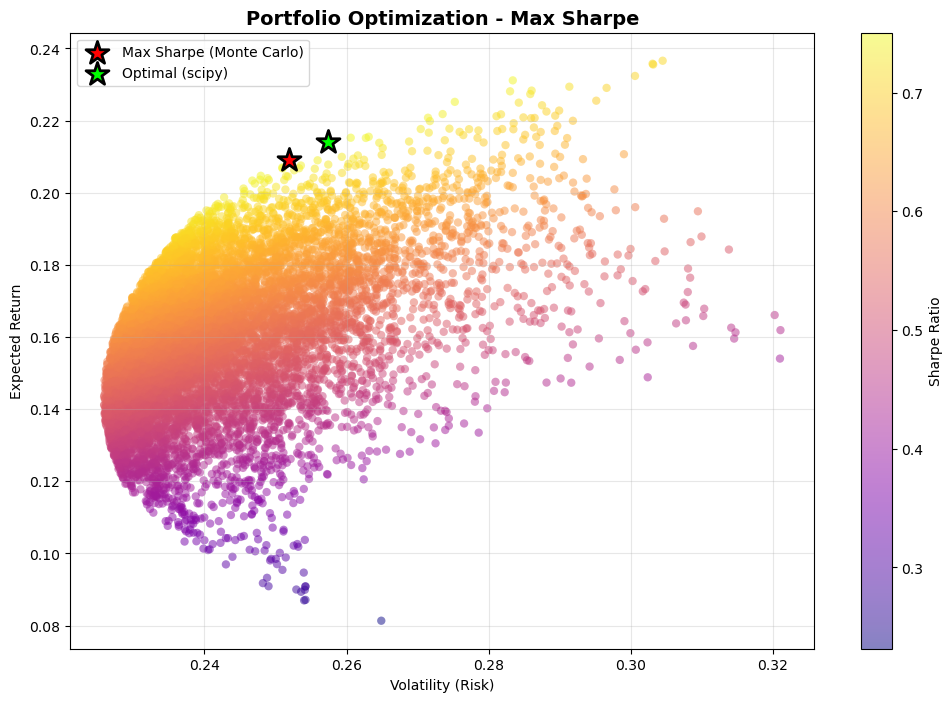

In [28]:
# Plot efficient frontier
plt.figure(figsize=(12, 8))

# Scatter plot of all Monte Carlo portfolios (color = Sharpe ratio)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.5, edgecolors='none')
plt.colorbar(label='Sharpe Ratio')

# Highlight max Sharpe portfolio (red star)
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=300, marker='*', 
            edgecolors='black', linewidths=2, label='Max Sharpe (Monte Carlo)', zorder=5)

# Add analytical optimum (green star)
opt_metrics = get_ret_vol_sr(opt_results.x)
plt.scatter(opt_metrics[1], opt_metrics[0], c='lime', s=300, marker='*',
            edgecolors='black', linewidths=2, label='Optimal (scipy)', zorder=5)

plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Portfolio Optimization - Max Sharpe', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

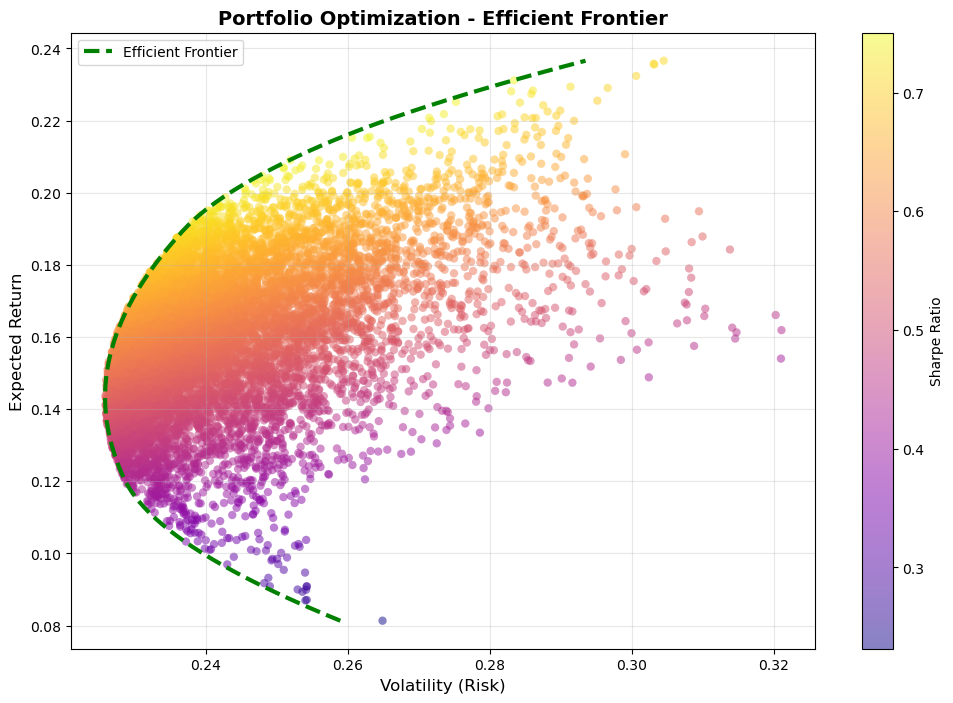


Efficient Frontier:
- Green line = optimal portfolios (max return for given risk)
- All other portfolios are suboptimal (below the line)
- Upper-left = best risk/return tradeoff


In [27]:
# ═══════════════════════════════════════════════════════════════
# EFFICIENT FRONTIER - Calculate the optimal frontier curve
# ═══════════════════════════════════════════════════════════════
# The efficient frontier shows the set of optimal portfolios that offer
# the highest expected return for a given level of risk (volatility)

# Function to minimize: portfolio volatility
def minimize_vol(weights):
    """Return portfolio volatility (to be minimized)"""
    return get_ret_vol_sr(weights)[1]

# Define range of target returns to trace the frontier
# Create 100 points between min and max portfolio returns from simulation
frontier_y = np.linspace(ret_arr.min(), ret_arr.max(), 100)

# Initialize list to store optimal volatilities
frontier_vol = []

# For each target return, find the portfolio with minimum volatility
for possible_return in frontier_y:
    # Constraints:
    # 1. Weights sum to 1 (fully invested)
    # 2. Portfolio return equals target return
    cons = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return}
    )
    
    # Minimize volatility subject to constraints
    result = minimize(minimize_vol, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    
    # Store the minimum volatility for this target return
    frontier_vol.append(result['fun'])

# Plot efficient frontier
plt.figure(figsize=(12, 8))

# Scatter plot: all simulated portfolios (color = Sharpe ratio)
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=0.5, edgecolors='none')
plt.colorbar(label='Sharpe Ratio')

# Plot efficient frontier (green dashed line)
plt.plot(frontier_vol, frontier_y, 'g--', linewidth=3, label='Efficient Frontier')

plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Portfolio Optimization - Efficient Frontier', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

print("\nEfficient Frontier:")
print("- Green line = optimal portfolios (max return for given risk)")
print("- All other portfolios are suboptimal (below the line)")
print("- Upper-left = best risk/return tradeoff")

## Key Takeaways

### Two Optimization Methods:

**1. Monte Carlo Simulation:**
- Easy to understand and visualize
- Shows entire efficient frontier
- Only approximates optimal solution
- Computationally intensive

**2. Analytical Optimization (scipy.optimize):**
- Finds exact optimal solution
- Faster and more precise
- Can add complex constraints
- Less intuitive (black box)

### This IS Modern Portfolio Theory (Markowitz):
Both methods implement Markowitz portfolio optimization:
- Maximize Sharpe ratio = find portfolio on efficient frontier
- Uses mean-variance framework
- Accounts for correlations between assets

---
*Note: Real-world considerations include transaction costs, taxes, rebalancing frequency, and constraints on individual positions*